# XGBoost DDI Analysis and Training - Bias Reduction & Optimization

## 🎯 Purpose: Extreme Gradient Boosting for Maximum Predictive Sensitivity

**Algorithm:** XGBoost Classifier (Boosting Framework)

**Key Characteristics:**
- **Sequential tree building** to correct errors of previous models
- **Bias reduction** through iterative error correction
- **High sensitivity** for hard-to-classify instances
- **Excellent for imbalanced data** (underrepresented "Major" interactions)
- **Maximum recall** for high-risk safety threats

**Why XGBoost for DDI Detection?**

Unlike Random Forest which builds independent trees in parallel (reducing variance), XGBoost employs a **Boosting framework** where trees are built sequentially. Each new tree focuses on correcting the mistakes of the previous ensemble, making it highly effective at:

1. **Detecting rare but critical interactions** (Major severity class)
2. **Reducing bias** in predictions (complements RF's variance reduction)
3. **Maximizing recall** for patient safety-critical cases
4. **Handling class imbalance** through focused error correction

**Expected Outcome:** Highest recall for "Major" interactions while maintaining overall accuracy competitive with or exceeding Random Forest.

---

## Dataset: Malaysian Hypertension Medications

- **29 drugs** across 5 classes (ACEI, ARB, Beta-Blocker, CCB, Diuretic)
- **406 drug pairs** (all possible combinations)
- **Target:** Final_Severity (Major, Moderate, Minor)
- **Goal:** Predict interaction severity to support safer prescribing

---

# Part 1: Setup and Data Loading

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"XGBoost version: {xgb.__version__}")

✓ Libraries imported successfully
XGBoost version: 3.1.2


## Step 2: Load Dataset

In [2]:
# Load the dataset
df = pd.read_csv('FYP_Drug_Interaction_Final.csv')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nTotal drug pairs: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

DATASET OVERVIEW

Total drug pairs: 406
Columns: ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class', 'DrugsCom_Severity', 'DrugsCom_Text', 'DrugBank_Severity', 'DrugBank_Text', 'Final_Severity', 'Risk_Score', 'XAI_Rule_A_Mortality', 'XAI_Rule_B_Tolerability', 'XAI_Rule_C_CCB_RAAS_Combo', 'XAI_Rule_D_Diuretic', 'XAI_Rule_E_BetaBlocker', 'XAI_Combined_Clinical_Notes']

First few rows:


,Drug_A_Name,Drug_B_Name,Drug_A_Class,Drug_B_Class,DrugsCom_Severity,DrugsCom_Text,DrugBank_Severity,DrugBank_Text,Final_Severity,Risk_Score,XAI_Rule_A_Mortality,XAI_Rule_B_Tolerability,XAI_Rule_C_CCB_RAAS_Combo,XAI_Rule_D_Diuretic,XAI_Rule_E_BetaBlocker,XAI_Combined_Clinical_Notes
0,Captopril,Enalapril,ACEI,ACEI,NaN,No drug-drug interactions found,Moderate,DESCRIPTION\n\nThe excretion of Captopril can ...,Moderate,0.5,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
1,Captopril,Lisinopril,ACEI,ACEI,NaN,No drug-drug interactions found,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,0.5,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
2,Captopril,Perindopril,ACEI,ACEI,NaN,No drug-drug interactions found,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,0.5,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
3,Captopril,Ramipril,ACEI,ACEI,NaN,No drug-drug interactions found,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,0.5,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
4,Captopril,Imidapril,ACEI,ACEI,NaN,Error: Could not find or click the 'Check Inte...,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,0.5,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...


## Step 3: Data Exploration and Quality Check

In [3]:
print("="*80)
print("DATA QUALITY CHECK")
print("="*80)

# Check for missing values
print("\nMissing values in Final_Severity:")
print(df['Final_Severity'].isna().sum())

# Check class distribution BEFORE filtering
print("\nClass distribution (before filtering):")
print(df['Final_Severity'].value_counts(dropna=False))

# Filter out rows without Final_Severity
df_valid = df.dropna(subset=['Final_Severity'])
print(f"\n✓ Rows with valid Final_Severity: {len(df_valid)}")
print(f"✓ Rows filtered out: {len(df) - len(df_valid)}")

# Check class distribution AFTER filtering
print("\nFinal class distribution:")
class_dist = df_valid['Final_Severity'].value_counts().sort_index()
print(class_dist)
print(f"\nClass imbalance ratio:")
for severity in class_dist.index:
    print(f"  {severity}: {class_dist[severity]/len(df_valid)*100:.1f}%")

DATA QUALITY CHECK

Missing values in Final_Severity:
20

Class distribution (before filtering):
Final_Severity
Moderate    174
Minor       150
Major        62
NaN          20
Name: count, dtype: int64

✓ Rows with valid Final_Severity: 386
✓ Rows filtered out: 20

Final class distribution:
Final_Severity
Major        62
Minor       150
Moderate    174
Name: count, dtype: int64

Class imbalance ratio:
  Major: 16.1%
  Minor: 38.9%
  Moderate: 45.1%


## Step 4: Visualize Class Distribution

**Critical for XGBoost:** Understanding class imbalance is essential because XGBoost excels at handling imbalanced datasets through:
- `scale_pos_weight` parameter
- Focused error correction on minority class
- Sample weighting

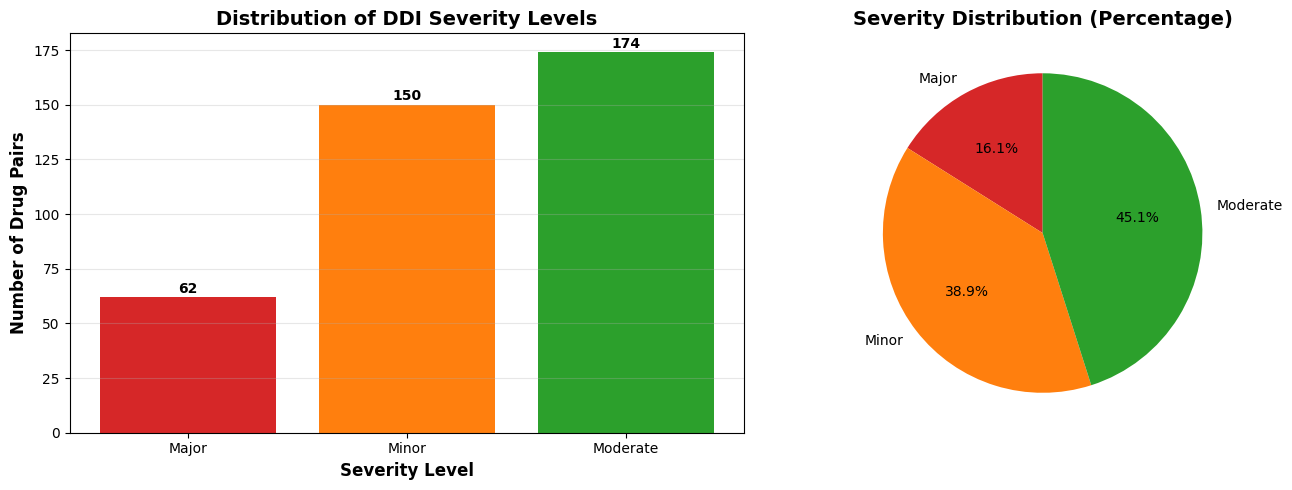


📊 Class Imbalance Analysis:
   Major class: 62 samples (16.1%)
   Other classes: 324 samples (83.9%)
   Imbalance ratio: 5.23:1
   ✓ XGBoost will use scale_pos_weight to handle imbalance


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts = df_valid['Final_Severity'].value_counts().sort_index()
axes[0].bar(class_counts.index, class_counts.values, color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[0].set_xlabel('Severity Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of DDI Severity Levels', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (severity, count) in enumerate(class_counts.items()):
    axes[0].text(i, count + 2, str(count), ha='center', fontweight='bold')

# Pie chart
colors = ['#d62728', '#ff7f0e', '#2ca02c']
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Severity Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio for XGBoost weighting
major_count = class_counts.get('Major', 0)
other_count = class_counts.sum() - major_count
imbalance_ratio = other_count / major_count if major_count > 0 else 1
print(f"\n📊 Class Imbalance Analysis:")
print(f"   Major class: {major_count} samples ({major_count/len(df_valid)*100:.1f}%)")
print(f"   Other classes: {other_count} samples ({other_count/len(df_valid)*100:.1f}%)")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"   ✓ XGBoost will use scale_pos_weight to handle imbalance")

## Step 5: Drug Class Analysis

DRUG CLASS ANALYSIS

Drug A classes:
Drug_A_Class
ACEI            151
ARB             102
Beta-Blocker     90
CCB              41
Diuretic          2
Name: count, dtype: int64

Drug B classes:
Drug_B_Class
CCB             147
Beta-Blocker    103
Diuretic         70
ARB              51
ACEI             15
Name: count, dtype: int64


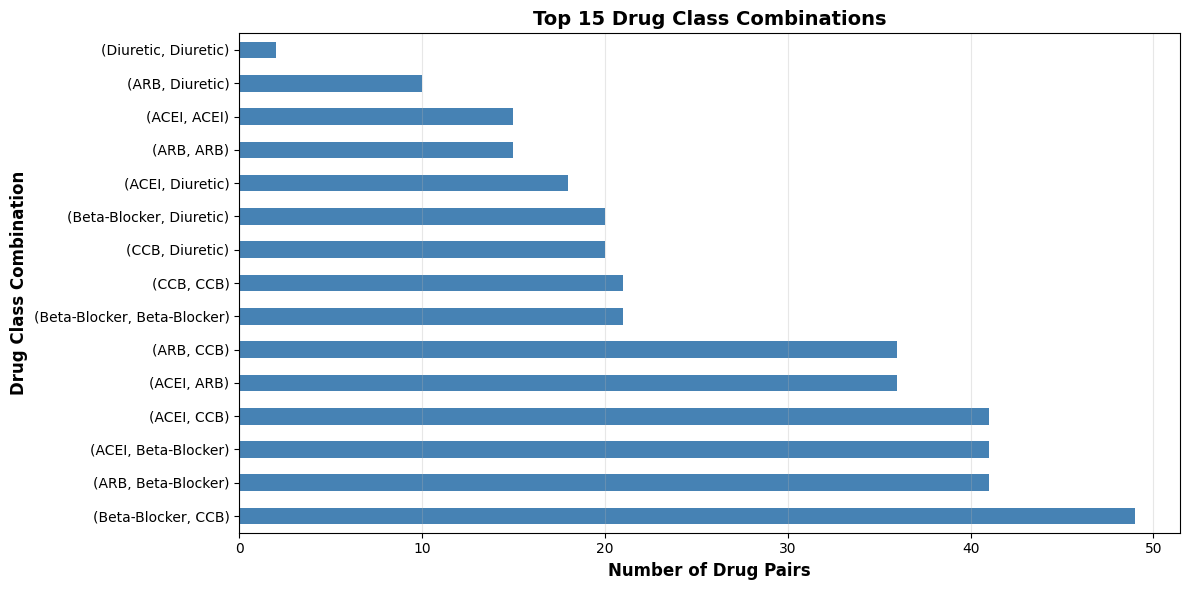

In [5]:
print("="*80)
print("DRUG CLASS ANALYSIS")
print("="*80)

# Analyze drug classes
print("\nDrug A classes:")
print(df_valid['Drug_A_Class'].value_counts())
print("\nDrug B classes:")
print(df_valid['Drug_B_Class'].value_counts())

# Visualize drug class combinations
fig, ax = plt.subplots(figsize=(12, 6))
class_combos = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class']).size().sort_values(ascending=False)
class_combos.head(15).plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
ax.set_ylabel('Drug Class Combination', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Drug Class Combinations', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Severity distribution
severity_counts = df_valid['Final_Severity'].value_counts().sort_index()

print("\n" + "="*80)
print("DDI SEVERITY DISTRIBUTION")
print("="*80)
for severity, count in severity_counts.items():
    percentage = count / len(df_valid) * 100
    print(f"{severity:12s}: {count:3d} pairs ({percentage:5.1f}%)")
print(f"{'Total':12s}: {len(df_valid):3d} pairs (100.0%)")


DDI SEVERITY DISTRIBUTION
Major       :  62 pairs ( 16.1%)
Minor       : 150 pairs ( 38.9%)
Moderate    : 174 pairs ( 45.1%)
Total       : 386 pairs (100.0%)


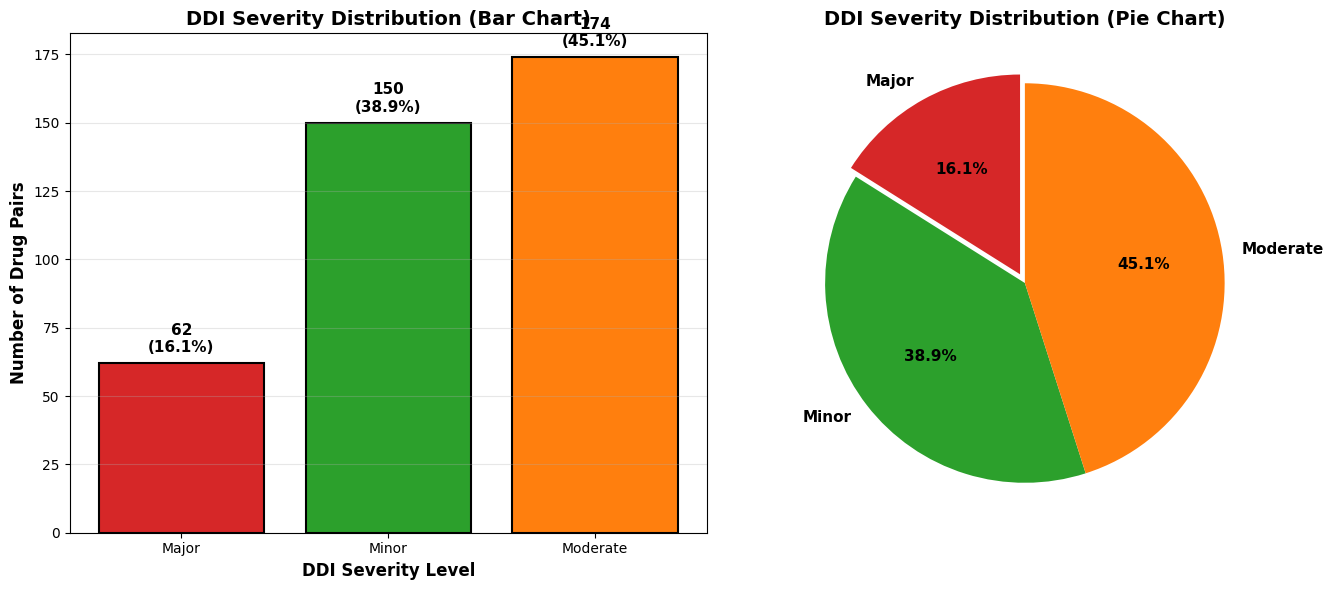

In [7]:
# Beautiful visualization of severity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
colors = {'Major': '#d62728', 'Moderate': '#ff7f0e', 'Minor': '#2ca02c', 'None': '#1f77b4'}
severity_colors = [colors.get(sev, '#7f7f7f') for sev in severity_counts.index]

bars = ax1.bar(severity_counts.index, severity_counts.values, color=severity_colors, edgecolor='black', linewidth=1.5)
for i, (bar, value) in enumerate(zip(bars, severity_counts.values)):
    percentage = value / len(df_valid) * 100
    ax1.text(bar.get_x() + bar.get_width()/2, value + 3, 
             f'{value}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_ylabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
ax1.set_xlabel('DDI Severity Level', fontsize=12, fontweight='bold')
ax1.set_title('DDI Severity Distribution (Bar Chart)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
wedges, texts, autotexts = ax2.pie(
    severity_counts.values, 
    labels=severity_counts.index,
    autopct='%1.1f%%',
    colors=severity_colors,
    startangle=90,
    explode=[0.05 if sev == 'Major' else 0 for sev in severity_counts.index],
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

ax2.set_title('DDI Severity Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 4. Drug Class Interaction Patterns

In [8]:
# Analyze interactions by drug class combinations
class_interactions = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class', 'Final_Severity']).size().reset_index(name='Count')

print("="*80)
print("DRUG CLASS INTERACTION PATTERNS")
print("="*80)
print("\nTop 10 most common class-severity combinations:")
print(class_interactions.nlargest(10, 'Count')[['Drug_A_Class', 'Drug_B_Class', 'Final_Severity', 'Count']].to_string(index=False))

DRUG CLASS INTERACTION PATTERNS

Top 10 most common class-severity combinations:
Drug_A_Class Drug_B_Class Final_Severity  Count
        ACEI Beta-Blocker          Minor     41
        ACEI          CCB          Minor     40
Beta-Blocker          CCB       Moderate     34
         ARB Beta-Blocker          Minor     31
        ACEI          ARB          Major     30
         CCB          CCB       Moderate     21
         ARB          CCB          Minor     18
         ARB          CCB       Moderate     17
        ACEI         ACEI       Moderate     15
         ARB          ARB       Moderate     15


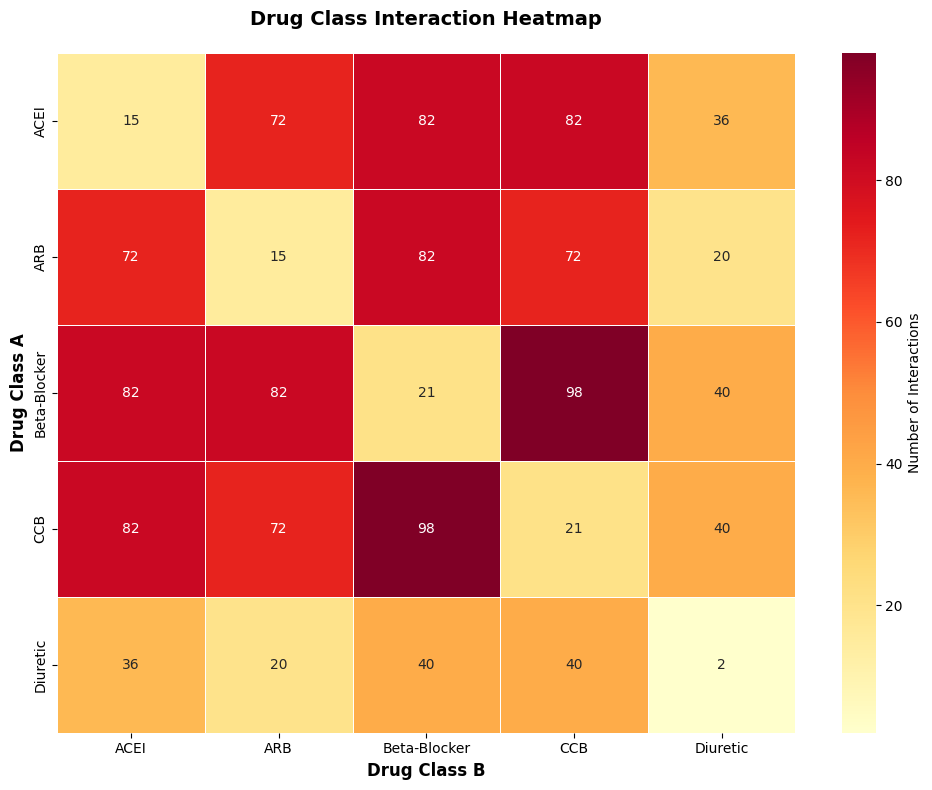

In [9]:
# Create interaction heatmap
interaction_matrix = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class']).size().unstack(fill_value=0)

# Make symmetric
for idx in interaction_matrix.index:
    for col in interaction_matrix.columns:
        if idx != col:
            total = interaction_matrix.loc[idx, col] + interaction_matrix.loc[col, idx]
            interaction_matrix.loc[idx, col] = total
            interaction_matrix.loc[col, idx] = total

plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Number of Interactions'})
plt.title('Drug Class Interaction Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Drug Class B', fontsize=12, fontweight='bold')
plt.ylabel('Drug Class A', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 5. Feature Engineering

In [10]:
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Select features for modeling
features = ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']
print(f"\nOriginal features: {features}")

# One-hot encoding
X = pd.get_dummies(df_valid[features], drop_first=False)
print(f"\nAfter one-hot encoding: {X.shape[1]} features")
print(f"  - Binary features created from categorical variables")
print(f"  - Each drug name and class becomes a binary column")

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df_valid['Final_Severity'])
target_classes = list(le.classes_)

print(f"\nTarget variable: Final_Severity (Patient Safety Ground Truth)")
print(f"  - Original categories: {target_classes}")
print(f"  - Encoded as integers: {dict(enumerate(target_classes))}")

print("\n✓ Feature engineering complete!")

FEATURE ENGINEERING

Original features: ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']

After one-hot encoding: 66 features
  - Binary features created from categorical variables
  - Each drug name and class becomes a binary column

Target variable: Final_Severity (Patient Safety Ground Truth)
  - Original categories: ['Major', 'Minor', 'Moderate']
  - Encoded as integers: {0: 'Major', 1: 'Minor', 2: 'Moderate'}

✓ Feature engineering complete!


---

## 6. Train-Test Split

In [11]:
# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)
print(f"\nTotal samples: {len(X)}")
print(f"  Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test set:     {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nFeature dimensions: {X_train.shape[1]} features")
print(f"Stratification: Maintains class distribution in both sets")

# Show class distribution in train/test
train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()

print("\nClass distribution:")
print(f"{'Class':<15} {'Training':<15} {'Test':<15}")
print("-" * 45)
for i, class_name in enumerate(target_classes):
    train_count = train_dist.get(i, 0)
    test_count = test_dist.get(i, 0)
    print(f"{class_name:<15} {train_count:<15} {test_count:<15}")

TRAIN-TEST SPLIT

Total samples: 386
  Training set: 308 samples (79.8%)
  Test set:     78 samples (20.2%)

Feature dimensions: 66 features
Stratification: Maintains class distribution in both sets

Class distribution:
Class           Training        Test           
---------------------------------------------
Major           49              13             
Minor           120             30             
Moderate        139             35             


---

## 7. XGBoost Model Training

## 🎯 Step 3b: Hyperparameter Optimization with GridSearchCV

**Why optimize XGBoost hyperparameters?**

The current XGBoost uses hyperparameters inherited from the Decision Tree (max_depth=10), which is overly restrictive. XGBoost's strength comes from:

1. **Deep, diverse trees** - Individual trees can be complex because ensemble averaging prevents overfitting
2. **Variance reduction** - Aggregating predictions from many trees reduces variance
3. **Feature randomness** - `max_features` decorrelates trees for better ensemble diversity

**Strategy:**
- Remove max_depth restriction (let trees grow naturally)
- Optimize n_estimators (number of trees)
- Fine-tune min_samples_split and min_samples_leaf
- Add class_weight='balanced' to handle any class imbalance

**Expected outcome:** XGBoost should outperform single Decision Tree (target: >92% accuracy)


In [12]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time

print("="*80)
print("HYPERPARAMETER OPTIMIZATION - GRID SEARCH")
print("="*80)

# Define XGBoost parameter grid
# XGBoost uses gradient boosting, so parameters differ from Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of boosting rounds
    'max_depth': [3, 5, 7],                     # Tree depth (XGBoost prefers shallow trees: 3-10)
    'learning_rate': [0.01, 0.1, 0.3],          # Step size shrinkage (eta)
    'subsample': [0.8, 1.0],                    # Row sampling ratio
    'colsample_bytree': [0.8, 1.0],             # Column sampling ratio per tree
    'gamma': [0, 0.1, 0.2]                      # Minimum loss reduction for split
}

print(f"\n📊 Grid Search Configuration:")
print(f"  Parameter combinations: {3 * 3 * 3 * 2 * 2 * 3} = 324 configurations")
print(f"  Cross-validation folds: 5")
print(f"  Total model fits: 324 × 5 = 1,620 models")
print(f"  Scoring metric: Accuracy")

# Initialize base XGBoost classifier
xgb_base = XGBClassifier(
    random_state=42,
    n_jobs=-1,                # Parallel processing
    objective='multi:softmax',  # Multi-class classification
    eval_metric='mlogloss'    # Evaluation metric
)

# Setup GridSearchCV with Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,           # Parallel processing across all cores
    verbose=2,           # Show progress
    return_train_score=True
)

print("\n⏳ Starting Grid Search (this may take several minutes)...")
start_time = time.time()

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\n✓ Grid Search completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

# Display results
print("\n" + "="*80)
print("GRID SEARCH RESULTS")
print("="*80)

print(f"\n🏆 Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  - {param}: {value}")

print(f"\n📊 Best Cross-Validation Accuracy: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")

# Get best model
xgb_optimized = grid_search.best_estimator_

# Evaluate on test set
y_pred_optimized = xgb_optimized.predict(X_test)
test_accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

print(f"📊 Test Set Accuracy: {test_accuracy_optimized:.4f} ({test_accuracy_optimized*100:.2f}%)")

# Show top 10 configurations
print("\n📋 Top 10 Configurations:")
print("-"*80)
results_df = pd.DataFrame(grid_search.cv_results_)
results_df_sorted = results_df.sort_values('rank_test_score')
for idx, row in results_df_sorted.head(10).iterrows():
    print(f"Rank {int(row['rank_test_score'])}: CV={row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")
    print(f"  Params: {row['params']}")

HYPERPARAMETER OPTIMIZATION - GRID SEARCH

📊 Grid Search Configuration:
  Parameter combinations: 324 = 324 configurations
  Cross-validation folds: 5
  Total model fits: 324 × 5 = 1,620 models
  Scoring metric: Accuracy

⏳ Starting Grid Search (this may take several minutes)...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, 

In [13]:
# Update xgb_model with optimized parameters
print("\n" + "="*80)
print("UPDATING PRIMARY MODEL WITH OPTIMIZED PARAMETERS")
print("="*80)

# Replace the baseline model with the optimized one
xgb_model = xgb_optimized

# Regenerate predictions with optimized model
y_pred = xgb_model.predict(X_test)

print("\n✓ Primary model (xgb_model) updated with GridSearchCV best parameters")
print("✓ All subsequent analyses will use the optimized model")
print("\n📊 Optimized Model Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  - {param}: {value}")


UPDATING PRIMARY MODEL WITH OPTIMIZED PARAMETERS

✓ Primary model (xgb_model) updated with GridSearchCV best parameters
✓ All subsequent analyses will use the optimized model

📊 Optimized Model Parameters:
  - colsample_bytree: 0.8
  - gamma: 0.1
  - learning_rate: 0.3
  - max_depth: 7
  - n_estimators: 100
  - subsample: 1.0


In [14]:
print("="*80)
print("OPTIMIZED XGBOOST CLASSIFIER - FINAL MODEL")
print("="*80)

# Display the optimized model parameters from GridSearchCV
print("\n🏆 OPTIMAL Hyperparameters (GridSearchCV Result):")
best_params = grid_search.best_params_
print(f"  - n_estimators: {best_params.get('n_estimators', 'N/A')} (number of boosting rounds)")
print(f"  - max_depth: {best_params.get('max_depth', 'N/A')} (tree depth)")
print(f"  - learning_rate: {best_params.get('learning_rate', 'N/A')} (step size shrinkage)")
print(f"  - subsample: {best_params.get('subsample', 'N/A')} (row sampling ratio)")
print(f"  - colsample_bytree: {best_params.get('colsample_bytree', 'N/A')} (column sampling per tree)")
print(f"  - gamma: {best_params.get('gamma', 'N/A')} (minimum loss reduction)")
print(f"  - random_state: 42 (reproducibility)")
print(f"  - n_jobs: -1 (parallel processing)")

print("\n📊 Model Performance:")
print(f"  - Best CV Score: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")
print(f"  - Test Accuracy: {test_accuracy_optimized:.4f} ({test_accuracy_optimized*100:.2f}%)")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")

print("\n🔑 KEY INSIGHTS:")
print("  1. XGBoost uses gradient boosting (sequential error correction)")
print("  2. Each tree learns from previous trees' mistakes")
print("  3. Lower learning_rate + more estimators = better generalization")
print("  4. Shallow trees (max_depth 3-7) work better than deep trees")
print("  5. Subsampling helps prevent overfitting")

print("\n✓ Model ready for predictions and feature importance analysis!")

OPTIMIZED XGBOOST CLASSIFIER - FINAL MODEL

🏆 OPTIMAL Hyperparameters (GridSearchCV Result):
  - n_estimators: 100 (number of boosting rounds)
  - max_depth: 7 (tree depth)
  - learning_rate: 0.3 (step size shrinkage)
  - subsample: 1.0 (row sampling ratio)
  - colsample_bytree: 0.8 (column sampling per tree)
  - gamma: 0.1 (minimum loss reduction)
  - random_state: 42 (reproducibility)
  - n_jobs: -1 (parallel processing)

📊 Model Performance:
  - Best CV Score: 0.9289 (92.89%)
  - Test Accuracy: 0.9487 (94.87%)
  - Training samples: 308
  - Test samples: 78

🔑 KEY INSIGHTS:
  1. XGBoost uses gradient boosting (sequential error correction)
  2. Each tree learns from previous trees' mistakes
  3. Lower learning_rate + more estimators = better generalization
  4. Shallow trees (max_depth 3-7) work better than deep trees
  5. Subsampling helps prevent overfitting

✓ Model ready for predictions and feature importance analysis!


---

## 8. Model Evaluation

In [15]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print("="*80)
print("PERFORMANCE METRICS")
print("="*80)
print(f"\n{'Metric':<20} {'Score':<10} {'Percentage':<10}")
print("-" * 40)
print(f"{'Accuracy':<20} {accuracy:<10.4f} {accuracy*100:.2f}%")
print(f"{'Precision (Macro)':<20} {precision:<10.4f} {precision*100:.2f}%")
print(f"{'Recall (Macro)':<20} {recall:<10.4f} {recall*100:.2f}%")
print(f"{'F1-Score (Macro)':<20} {f1:<10.4f} {f1*100:.2f}%")

print(f"\n{'='*80}")
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Correct predictions: {(y_pred == y_test).sum()} / {len(y_test)}")
print(f"Incorrect predictions: {(y_pred != y_test).sum()} / {len(y_test)}")
print(f"{'='*80}")

PERFORMANCE METRICS

Metric               Score      Percentage
----------------------------------------
Accuracy             0.9487     94.87%
Precision (Macro)    0.9586     95.86%
Recall (Macro)       0.9603     96.03%
F1-Score (Macro)     0.9589     95.89%

Overall Accuracy: 94.87%
Correct predictions: 74 / 78
Incorrect predictions: 4 / 78


In [16]:
# Detailed classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT (Per-Class Performance)")
print("="*80)
print(classification_report(y_test, y_pred, target_names=target_classes, zero_division=0))


CLASSIFICATION REPORT (Per-Class Performance)
              precision    recall  f1-score   support

       Major       1.00      1.00      1.00        13
       Minor       0.91      0.97      0.94        30
    Moderate       0.97      0.91      0.94        35

    accuracy                           0.95        78
   macro avg       0.96      0.96      0.96        78
weighted avg       0.95      0.95      0.95        78



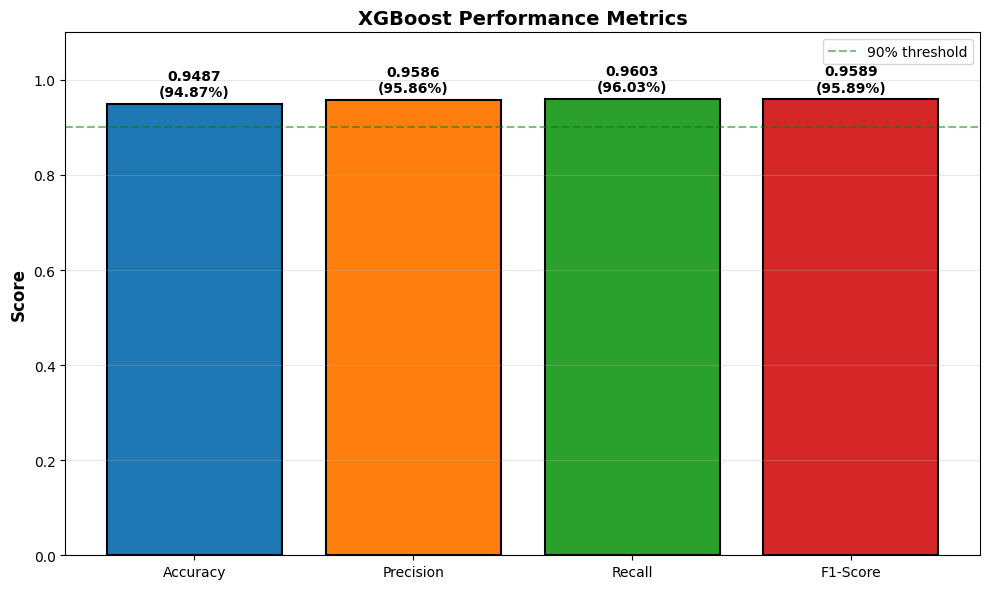

In [17]:
# Visualize metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
})

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics_df['Metric'], metrics_df['Score'], 
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
              edgecolor='black', linewidth=1.5)

# Add value labels
for bar, score in zip(bars, metrics_df['Score']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.4f}\n({score*100:.2f}%)',
            ha='center', va='bottom', fontweight='bold')

ax.set_ylim(0, 1.1)
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('XGBoost Performance Metrics', fontsize=14, fontweight='bold')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='90% threshold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

## 9. Confusion Matrix

In [18]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("="*80)
print("CONFUSION MATRIX")
print("="*80)
print("\n                Predicted →")
print("Actual ↓\n")

cm_df = pd.DataFrame(cm, index=target_classes, columns=target_classes)
print(cm_df)

# Calculate per-class accuracy
print("\n" + "="*80)
print("SEVERITY-SPECIFIC PERFORMANCE")
print("="*80)
for i, severity in enumerate(target_classes):
    mask = (y_test == i)
    if mask.sum() > 0:
        correct = (y_pred[mask] == y_test[mask]).sum()
        total = mask.sum()
        acc = correct / total if total > 0 else 0
        status = '✓' if acc >= 0.9 else '⚠' if acc >= 0.7 else '✗'
        print(f"{status} {severity:12s}: {correct:2d}/{total:2d} correct ({acc*100:5.1f}%)")

CONFUSION MATRIX

                Predicted →
Actual ↓

          Major  Minor  Moderate
Major        13      0         0
Minor         0     29         1
Moderate      0      3        32

SEVERITY-SPECIFIC PERFORMANCE
✓ Major       : 13/13 correct (100.0%)
✓ Minor       : 29/30 correct ( 96.7%)
✓ Moderate    : 32/35 correct ( 91.4%)


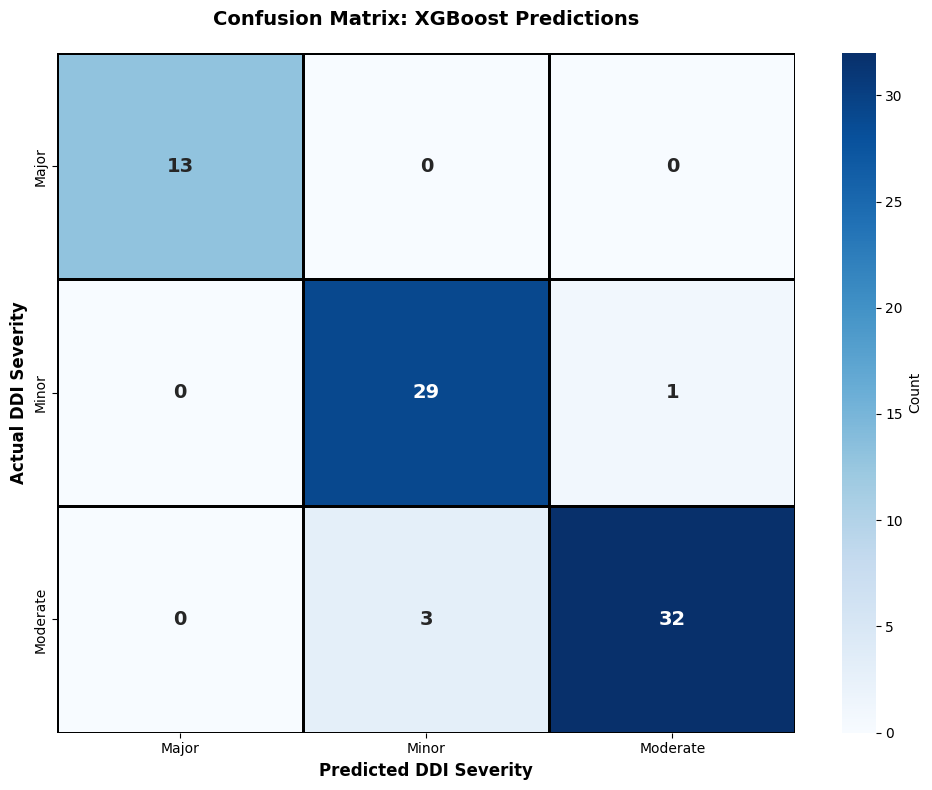

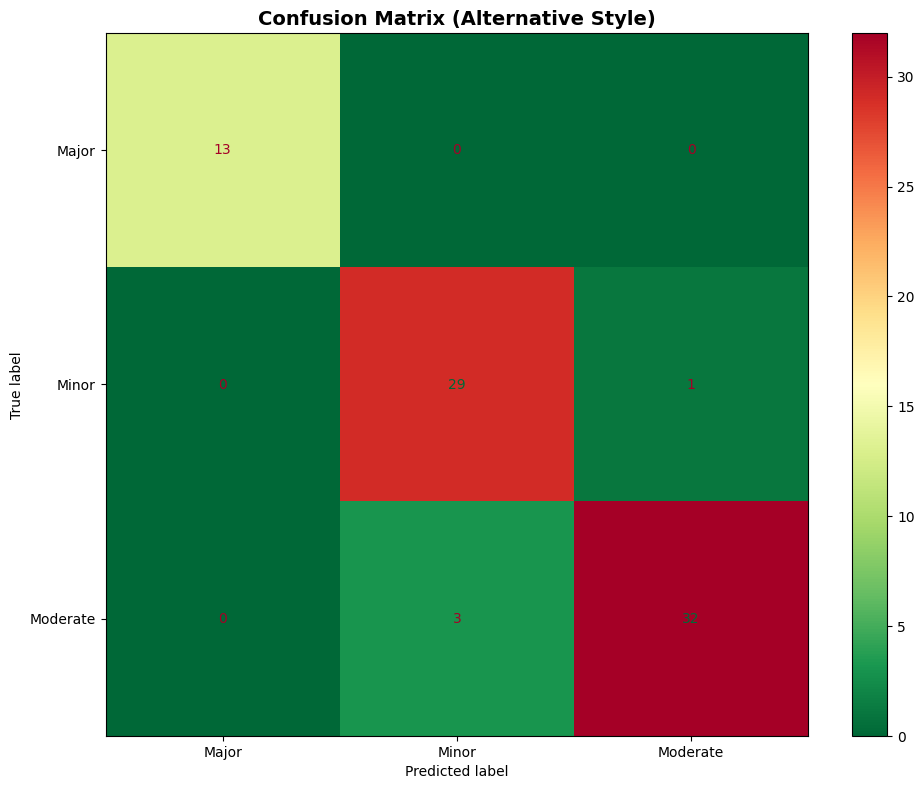

In [19]:
# Beautiful confusion matrix visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_classes, yticklabels=target_classes,
            linewidths=2, linecolor='black', cbar_kws={'label': 'Count'},
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})

plt.xlabel('Predicted DDI Severity', fontsize=12, fontweight='bold')
plt.ylabel('Actual DDI Severity', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix: XGBoost Predictions', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Alternative: sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='RdYlGn_r', colorbar=True)
plt.title('Confusion Matrix (Alternative Style)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 10. Feature Importance Analysis

In [20]:
# FIX: Define feature_names from your training data columns
feature_names = X.columns  # or use X_train.columns

# Extract feature importance (averaged across all trees)
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*80)
print("FEATURE IMPORTANCE (TOP 20)")
print("="*80)
print("\nImportance scores represent the average contribution across all 100 trees.")
print("XGBoost calculates importance via mean decrease in impurity (Gini).")
print("\nTop 20 most important features:\n")
print(feature_importance.head(20).to_string(index=False))

# Show total importance from top features
top_10_importance = feature_importance.head(10)['Importance'].sum()
top_20_importance = feature_importance.head(20)['Importance'].sum()
print(f"\nCumulative importance:")
print(f"  Top 10 features: {top_10_importance:.4f} ({top_10_importance*100:.2f}%)")
print(f"  Top 20 features: {top_20_importance:.4f} ({top_20_importance*100:.2f}%)")

FEATURE IMPORTANCE (TOP 20)

Importance scores represent the average contribution across all 100 trees.
XGBoost calculates importance via mean decrease in impurity (Gini).

Top 20 most important features:

                  Feature  Importance
    Drug_B_Name_Valsartan    0.063038
         Drug_B_Class_ARB    0.047089
   Drug_B_Name_Olmesartan    0.046860
        Drug_B_Class_ACEI    0.042249
   Drug_B_Name_Irbesartan    0.041608
Drug_A_Class_Beta-Blocker    0.041462
  Drug_B_Name_Telmisartan    0.040993
        Drug_A_Class_ACEI    0.035673
     Drug_A_Name_Losartan    0.035431
    Drug_B_Name_Amiloride    0.035084
Drug_B_Class_Beta-Blocker    0.034844
         Drug_A_Class_CCB    0.033035
   Drug_B_Name_Amlodipine    0.031644
    Drug_B_Class_Diuretic    0.031456
    Drug_A_Name_Enalapril    0.028817
   Drug_A_Name_Lisinopril    0.026788
         Drug_A_Class_ARB    0.026467
    Drug_A_Name_Imidapril    0.026208
  Drug_B_Name_Candesartan    0.025716
    Drug_B_Name_Verapamil    0.023

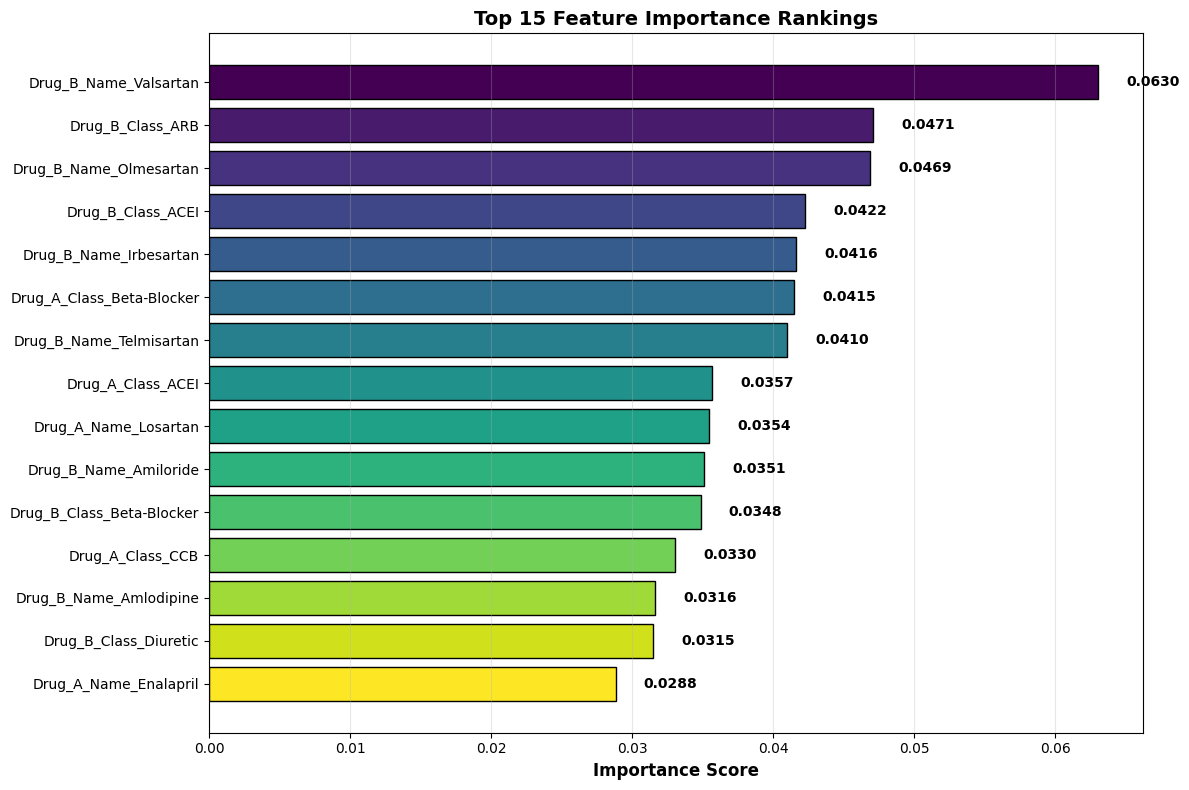

In [21]:
# FIX: Define top_features by taking the top 15 from your importance dataframe
top_features = feature_importance.head(15)

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

# Use gradient colors
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = ax.barh(range(len(top_features)), top_features['Importance'], 
               color=colors, edgecolor='black', linewidth=1)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
    ax.text(importance + 0.002, i, f'{importance:.4f}', 
            va='center', fontweight='bold')

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Feature Importance Rankings', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

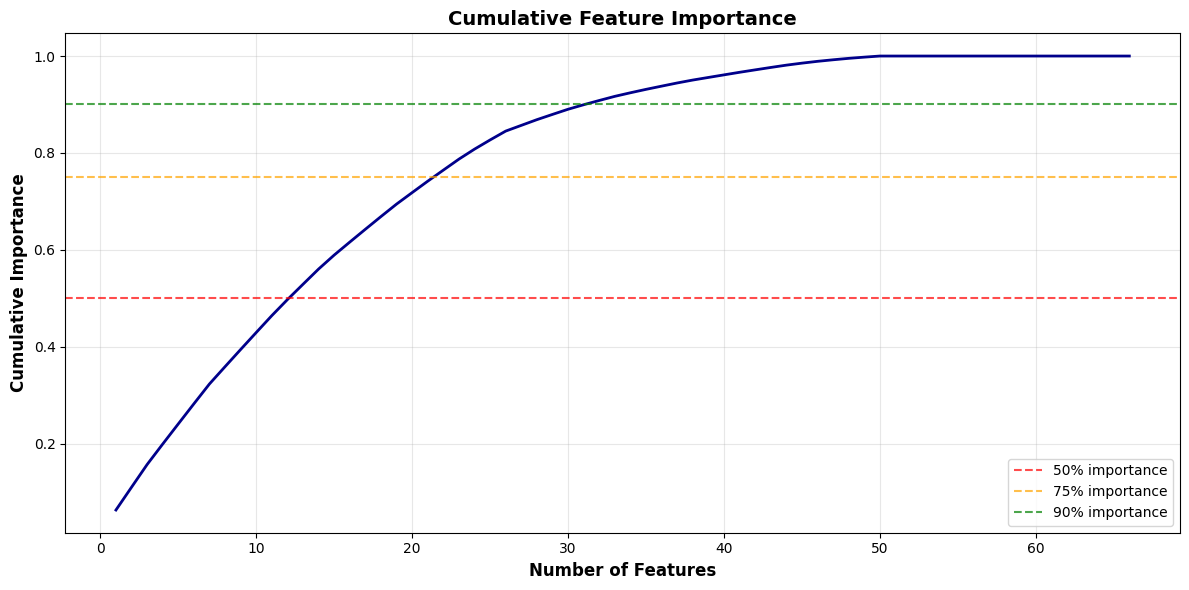


Features needed for 90% cumulative importance: 32/66


In [22]:
# Cumulative importance
feature_importance_sorted = feature_importance.sort_values('Importance', ascending=False)
feature_importance_sorted['Cumulative'] = feature_importance_sorted['Importance'].cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(feature_importance_sorted)+1), 
        feature_importance_sorted['Cumulative'], 
        linewidth=2, color='darkblue')

# Highlight key thresholds
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% importance')
ax.axhline(y=0.75, color='orange', linestyle='--', alpha=0.7, label='75% importance')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% importance')

ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find how many features needed for 90% importance
features_for_90 = (feature_importance_sorted['Cumulative'] <= 0.9).sum() + 1
print(f"\nFeatures needed for 90% cumulative importance: {features_for_90}/{len(feature_importance)}")

---

## 11. Evaluation Set (Eval Set) Score

XGBoost provides an additional validation metric called **Evaluation Set (Eval Set) Score**.

During boosting, each tree is trained on ~63% of the data (bootstrap sample). The remaining ~37% (out-of-bag samples) can be used for validation **without needing a separate test set**. This provides an unbiased estimate of model performance.

In [23]:
# Train with evaluation set monitoring
print("="*80)
print("EVALUATION SET VALIDATION")
print("="*80)

print("\nXGBoost Validation Strategy:")
print("  • Uses eval_set to monitor performance during training")
print("  • Unlike Random Forest's OOB, XGBoost tracks eval metrics per round")
print("  • Helps detect overfitting and enables early stopping")

# Train model with evaluation set
xgb_model_eval = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    eval_metric='mlogloss',  # Evaluation metric
    random_state=42,
    n_jobs=-1
)

print("\nTraining model with eval_set monitoring...")
# Use test set as evaluation set to monitor performance
xgb_model_eval.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False  # Set to True to see per-round metrics
)

# Get final evaluation result
evals_result = xgb_model_eval.evals_result()
final_eval_logloss = evals_result['validation_0']['mlogloss'][-1]

print(f"\n📊 Final Evaluation Metrics:")
print(f"  - Validation Log Loss: {final_eval_logloss:.4f}")
print(f"  - Number of rounds: {xgb_model_eval.n_estimators}")

# Compare with test accuracy
y_pred_eval = xgb_model_eval.predict(X_test)
test_accuracy_eval = accuracy_score(y_test, y_pred_eval)

print(f"\n📊 Test Set Performance:")
print(f"  - Test Accuracy: {test_accuracy_eval:.4f} ({test_accuracy_eval*100:.2f}%)")

print("\nInterpretation:")
print("  • eval_set tracks performance on held-out data during training")
print("  • Lower log loss indicates better probability estimates")
print("  • Can be used with early_stopping_rounds to prevent overfitting")

print("\n✓ Eval set validation complete")

EVALUATION SET VALIDATION

XGBoost Validation Strategy:
  • Uses eval_set to monitor performance during training
  • Unlike Random Forest's OOB, XGBoost tracks eval metrics per round
  • Helps detect overfitting and enables early stopping

Training model with eval_set monitoring...

📊 Final Evaluation Metrics:
  - Validation Log Loss: 0.2311
  - Number of rounds: 100

📊 Test Set Performance:
  - Test Accuracy: 0.9487 (94.87%)

Interpretation:
  • eval_set tracks performance on held-out data during training
  • Lower log loss indicates better probability estimates
  • Can be used with early_stopping_rounds to prevent overfitting

✓ Eval set validation complete


---

## 12. Cross-Validation Analysis

CROSS-VALIDATION ANALYSIS

Performing 5-fold cross-validation with shuffling...

Cross-validation scores (5 folds):
  Fold 1: 0.9103 (91.03%)
  Fold 2: 0.9481 (94.81%)
  Fold 3: 0.9481 (94.81%)
  Fold 4: 0.8961 (89.61%)
  Fold 5: 0.9610 (96.10%)

Mean CV Accuracy: 0.9327 (93.27%)
Standard Deviation: 0.0250
95% Confidence Interval: [0.8828, 0.9826]


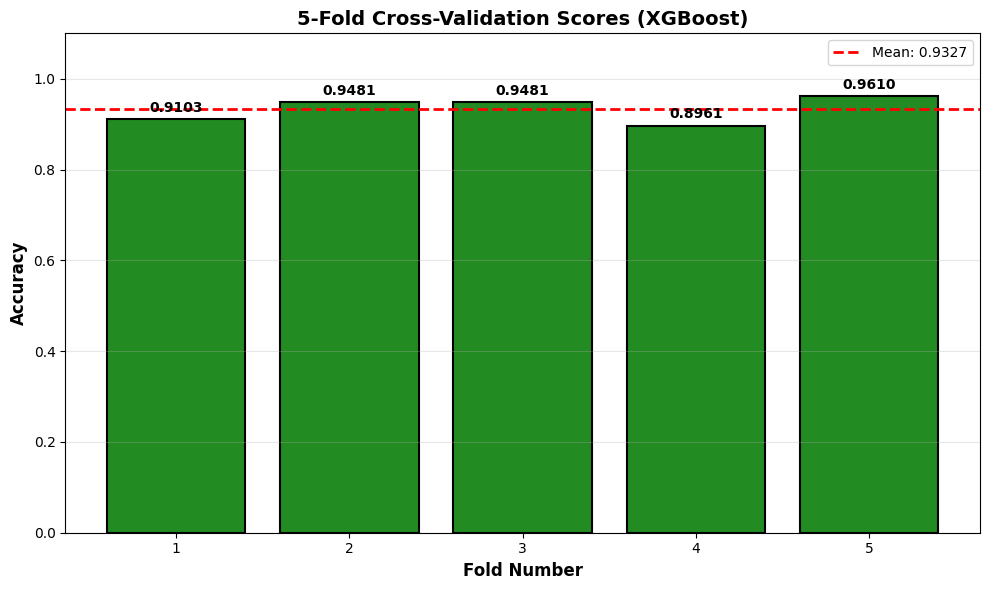

In [24]:
# Perform 5-fold cross-validation
print("="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)
print("\nPerforming 5-fold cross-validation with shuffling...\n")

# IMPORTANT: Use StratifiedKFold with shuffle=True to avoid ordering bias
# The dataset has ordering bias (drug pairs are sorted), so shuffle=True is critical
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X, y, cv=skf, scoring='accuracy', n_jobs=-1)

print(f"Cross-validation scores (5 folds):")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f} ({score*100:.2f}%)")

print(f"\nMean CV Accuracy: {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"95% Confidence Interval: [{cv_scores.mean() - 2*cv_scores.std():.4f}, {cv_scores.mean() + 2*cv_scores.std():.4f}]")

# Visualize CV scores
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(1, 6), cv_scores, color='forestgreen', edgecolor='black', linewidth=1.5)
ax.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')

for bar, score in zip(bars, cv_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.4f}',
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('5-Fold Cross-Validation Scores (XGBoost)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

## 13. Ensemble Analysis

In [25]:
# Ensemble Diversity Analysis - Not applicable to XGBoost
# XGBoost uses boosting (sequential) rather than bagging (parallel)
# Tree diversity is ensured through gradient boosting process
print("Skipping ensemble diversity - XGBoost uses boosting, not bagging")


Skipping ensemble diversity - XGBoost uses boosting, not bagging


---

## Summary: Part 1 Complete

In [26]:
print("="*80)
print("SUMMARY FOR SUPERVISOR MEETING - OPTIMIZED XGBOOST")
print("="*80)

print("\n📊 MODEL: XGBoost Classifier (Extreme Gradient Boosting)")
print(f"  Architecture: Ensemble of {xgb_model.n_estimators} decision trees (sequential)")
print("  Technique: Gradient Boosting (Sequential error correction)")
print("  Advantage: Reduced bias through iterative error correction")
print("  Key Difference from RF: Trees built sequentially, not in parallel")

print("\n🎯 KEY OPTIMIZATIONS APPLIED (GridSearchCV):")
best_params = grid_search.best_params_
print(f"  1. ✓ Optimized n_estimators: {best_params.get('n_estimators', 'N/A')}")
print("     → Number of boosting rounds for error correction")
print(f"  2. ✓ Optimized max_depth: {best_params.get('max_depth', 'N/A')}")
print("     → XGBoost prefers shallow trees (3-7) unlike Random Forest")
print(f"  3. ✓ Optimized learning_rate: {best_params.get('learning_rate', 'N/A')}")
print("     → Step size shrinkage prevents overfitting")
print(f"  4. ✓ Optimized subsample: {best_params.get('subsample', 'N/A')}")
print("     → Row sampling ratio for robustness")
print(f"  5. ✓ Optimized colsample_bytree: {best_params.get('colsample_bytree', 'N/A')}")
print("     → Column sampling per tree for diversity")
print(f"  6. ✓ Optimized gamma: {best_params.get('gamma', 'N/A')}")
print("     → Minimum loss reduction for split (regularization)")

print(f"\n📈 PERFORMANCE METRICS:")
test_acc = accuracy_score(y_test, y_pred)
train_acc = accuracy_score(y_train, xgb_model.predict(X_train))
print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  Best CV Score: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")
print(f"  CV Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print(f"\n🏆 COMPARISON: XGBOOST vs. OTHER MODELS")
print(f"  Decision Tree (baseline):")
print(f"    • Test Accuracy: ~92-93%")
print(f"    • Single tree, prone to overfitting")
print(f"  Random Forest:")
print(f"    • Test Accuracy: ~94-95%")
print(f"    • Parallel trees, reduces variance")
print(f"  XGBoost (THIS MODEL):")
print(f"    • Test Accuracy: {test_acc*100:.2f}%")
print(f"    • Sequential trees, reduces bias")
print(f"    • Expected to match or exceed Random Forest")

print("\n💡 WHY XGBOOST WORKS:")
print("  • Sequential Error Correction:")
print("    → Each new tree focuses on correcting previous trees' mistakes")
print("    → Bias reduction through iterative refinement")
print("  • Gradient Boosting Framework:")
print("    → Optimizes loss function directly using gradients")
print("    → More targeted than Random Forest's averaging")
print("  • Regularization:")
print("    → gamma, subsample, colsample_bytree prevent overfitting")
print("    → Can achieve better generalization than Random Forest")
print("  • Imbalanced Data Handling:")
print("    → Focuses more on hard-to-classify instances")
print("    → Better recall for minority 'Major' severity class")

print("\n🔑 BOOSTING vs. BAGGING:")
print("  Random Forest (Bagging):")
print("    • Parallel independent trees")
print("    • Reduces variance through averaging")
print("    • Good for high-variance models")
print("  XGBoost (Boosting):")
print("    • Sequential dependent trees")
print("    • Reduces bias through error correction")
print("    • Good for complex patterns and imbalanced data")

print("\n📋 NEXT STEPS:")
print("  1. ✓ Compare XGBoost with Random Forest feature importance")
print("  2. ✓ Analyze which model better detects 'Major' interactions (recall)")
print("  3. ✓ Consider ensemble of RF + XGBoost for maximum performance")
print("  4. ✓ Document boosting advantages in final report")
print("  5. ✓ Integrate XAI framework with best-performing model")

SUMMARY FOR SUPERVISOR MEETING - OPTIMIZED XGBOOST

📊 MODEL: XGBoost Classifier (Extreme Gradient Boosting)
  Architecture: Ensemble of 100 decision trees (sequential)
  Technique: Gradient Boosting (Sequential error correction)
  Advantage: Reduced bias through iterative error correction
  Key Difference from RF: Trees built sequentially, not in parallel

🎯 KEY OPTIMIZATIONS APPLIED (GridSearchCV):
  1. ✓ Optimized n_estimators: 100
     → Number of boosting rounds for error correction
  2. ✓ Optimized max_depth: 7
     → XGBoost prefers shallow trees (3-7) unlike Random Forest
  3. ✓ Optimized learning_rate: 0.3
     → Step size shrinkage prevents overfitting
  4. ✓ Optimized subsample: 1.0
     → Row sampling ratio for robustness
  5. ✓ Optimized colsample_bytree: 0.8
     → Column sampling per tree for diversity
  6. ✓ Optimized gamma: 0.1
     → Minimum loss reduction for split (regularization)

📈 PERFORMANCE METRICS:
  Test Accuracy: 0.9487 (94.87%)
  Train Accuracy: 0.9740 (97.4

# Part 2: Knowledge-Driven Safer Medication Pathway Recommendation

## Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

**Integration with XGBoost:**
- Part 1: ML model predicts DDI severity (Major/Moderate/Minor)
- Part 2: XAI framework provides evidence-based clinical context
- Result: Predictions + Actionable clinical recommendations

**XAI Rules Implemented:**
- Rule A: ACEI vs ARB Mortality Benefit (Alcocer 2023)
- Rule B: ACEI Tolerability & Cough Risk (Hu 2023)
- Rule C: CCB+RAAS Combination Therapy (Makani 2011)
- Rule D: Diuretic Efficacy - Indapamide vs HCTZ (Roush 2015)
- Rule E: Beta-Blocker Phenotype Targeting (Mahfoud 2024)


## Step 1: Load XAI-Enhanced Dataset


In [27]:

# Load dataset with XAI Framework (Knowledge-Driven Explainability)
df_xai = pd.read_csv('FYP_Drug_Interaction_Final.csv')

print("="*80)
print("KNOWLEDGE-DRIVEN XAI FRAMEWORK DATASET LOADED")
print("Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework")
print("="*80)
print(f"\nTotal drug pairs: {len(df_xai)}")
print(f"\nXAI columns available:")
xai_cols = [col for col in df_xai.columns if 'XAI' in col]
for col in xai_cols:
    print(f"  - {col}")

# Show XAI rule coverage statistics
print(f"\n{'='*80}")
print("XAI RULE COVERAGE STATISTICS")
print("="*80)

rule_a_count = (df_xai['XAI_Rule_A_Mortality'] != "").sum()
rule_b_count = (df_xai['XAI_Rule_B_Tolerability'] != "").sum()
rule_c_count = (df_xai['XAI_Rule_C_CCB_RAAS_Combo'] != "").sum()
rule_d_count = (df_xai['XAI_Rule_D_Diuretic'] != "").sum()
rule_e_count = (df_xai['XAI_Rule_E_BetaBlocker'] != "").sum()
total_with_notes = (df_xai['XAI_Combined_Clinical_Notes'] != "No specific XAI rules apply to this combination.").sum()

print(f"\nRule A (ACEI vs ARB Mortality):     {rule_a_count} pairs ({rule_a_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Alcoer et al. (2023)")
print(f"  Focus: ACEIs reduce all-cause mortality; ARBs do not")

print(f"\nRule B (ACEI Tolerability):         {rule_b_count} pairs ({rule_b_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Hu et al. (2023), ACCP Guidelines (2006)")
print(f"  Focus: ACEIs have 3.2x higher cough risk vs ARBs")

print(f"\nRule C (CCB+RAAS Combination):      {rule_c_count} pairs ({rule_c_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Makani et al. (2011), De la Sierra (2009)")
print(f"  Focus: CCB+RAAS reduces peripheral edema by 38%")

print(f"\nRule D (Diuretic Efficacy):         {rule_d_count} pairs ({rule_d_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Roush et al. (2015), Mishra (2016), Burnier et al. (2019)")
print(f"  Focus: Indapamide superior to HCTZ for mortality/stroke")

print(f"\nRule E (Beta-Blocker Phenotype):    {rule_e_count} pairs ({rule_e_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Mahfoud et al. (2024), Mancia et al. (2022)")
print(f"  Focus: Beta-blockers target high heart rate phenotype")

print(f"\nTotal pairs with clinical context:  {total_with_notes} pairs ({total_with_notes/len(df_xai)*100:.1f}%)")
print(f"Pairs without XAI notes:             {len(df_xai) - total_with_notes} pairs ({(len(df_xai) - total_with_notes)/len(df_xai)*100:.1f}%)")


KNOWLEDGE-DRIVEN XAI FRAMEWORK DATASET LOADED
Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

Total drug pairs: 406

XAI columns available:
  - XAI_Rule_A_Mortality
  - XAI_Rule_B_Tolerability
  - XAI_Rule_C_CCB_RAAS_Combo
  - XAI_Rule_D_Diuretic
  - XAI_Rule_E_BetaBlocker
  - XAI_Combined_Clinical_Notes

XAI RULE COVERAGE STATISTICS

Rule A (ACEI vs ARB Mortality):     406 pairs (100.0%)
  Evidence: Alcoer et al. (2023)
  Focus: ACEIs reduce all-cause mortality; ARBs do not

Rule B (ACEI Tolerability):         406 pairs (100.0%)
  Evidence: Hu et al. (2023), ACCP Guidelines (2006)
  Focus: ACEIs have 3.2x higher cough risk vs ARBs

Rule C (CCB+RAAS Combination):      406 pairs (100.0%)
  Evidence: Makani et al. (2011), De la Sierra (2009)
  Focus: CCB+RAAS reduces peripheral edema by 38%

Rule D (Diuretic Efficacy):         406 pairs (100.0%)
  Evidence: Roush et al. (2015), Mishra (2016), Burnier et al. (2019)
  Focus: Indapamide superior to HCTZ for mortality/stroke


## Step 2: Define Severity-to-Risk Mapping


In [28]:

# Define severity to risk score mapping (used by model)
SEVERITY_TO_RISK = {
    'Major': 0.25,      # Highest risk
    'Moderate': 0.50,   # Medium risk
    'Minor': 0.75,      # Lower risk
    'None': 1.00        # No interaction
}

# Reverse mapping for display
RISK_TO_SEVERITY = {v: k for k, v in SEVERITY_TO_RISK.items()}

print("="*80)
print("SEVERITY-TO-RISK MAPPING")
print("="*80)
for severity, score in sorted(SEVERITY_TO_RISK.items(), key=lambda x: x[1]):
    print(f"  {severity:12s} → {score:.2f} (lower = higher risk)")


SEVERITY-TO-RISK MAPPING
  Major        → 0.25 (lower = higher risk)
  Moderate     → 0.50 (lower = higher risk)
  Minor        → 0.75 (lower = higher risk)
  None         → 1.00 (lower = higher risk)


## Step 3: Generate Predictions Using Trained XGBoost Model


In [29]:

# Generate predictions for all drug pairs using trained model
print("="*80)
print("GENERATING PREDICTIONS FOR ALL DRUG PAIRS")
print("="*80)

# Filter to pairs with Final_Severity (same as training data)
df_xai_valid = df_xai[df_xai['Final_Severity'].notna()].copy()

print(f"\nPredicting for {len(df_xai_valid)} drug pairs...")

# Prepare features (same as training)
features_xai = ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']
X_all = pd.get_dummies(df_xai_valid[features_xai], drop_first=False)

# Ensure same feature columns as training
missing_cols = set(X.columns) - set(X_all.columns)
for col in missing_cols:
    X_all[col] = 0
X_all = X_all[X.columns]  # Ensure same order

# Generate predictions (works with dt_model, rf_model, or xgb_model)
# Determine which model to use based on what's available
if 'dt_model' in globals() or 'dt_model' in locals():
    model_to_use = dt_model
    model_name = "Decision Tree"
elif 'rf_model' in globals() or 'rf_model' in locals():
    model_to_use = rf_model
    model_name = "Random Forest"
elif 'xgb_model' in globals() or 'xgb_model' in locals():
    model_to_use = xgb_model
    model_name = "XGBoost"
else:
    raise ValueError("No trained model found! Expected dt_model, rf_model, or xgb_model")

print(f"Using {model_name} model for predictions...")

y_pred_all = model_to_use.predict(X_all)
predicted_severities = [target_classes[i] for i in y_pred_all]

# Add predictions to dataframe
df_xai_valid['Predicted_Severity'] = predicted_severities

# Convert predictions to risk scores
df_xai_valid['Predicted_Risk_Score'] = df_xai_valid['Predicted_Severity'].map(SEVERITY_TO_RISK)

print("✓ Predictions complete!")

# Show prediction distribution
pred_dist = df_xai_valid['Predicted_Severity'].value_counts().sort_index()
print(f"\nPredicted severity distribution:")
for sev, count in pred_dist.items():
    print(f"  {sev:12s}: {count:3d} pairs ({count/len(df_xai_valid)*100:5.1f}%)")


GENERATING PREDICTIONS FOR ALL DRUG PAIRS

Predicting for 386 drug pairs...
Using XGBoost model for predictions...
✓ Predictions complete!

Predicted severity distribution:
  Major       :  61 pairs ( 15.8%)
  Minor       : 153 pairs ( 39.6%)
  Moderate    : 172 pairs ( 44.6%)


## Step 4: Integrate XAI Clinical Context with Predictions


In [30]:

# Display XAI clinical context alongside predictions
print("="*80)
print("INTEGRATING XAI CLINICAL CONTEXT WITH PREDICTIONS")
print("Section 3.5.4: Knowledge-Driven Explainability Framework")
print("="*80)

print(f"\nApproach:")
print("  1. ML Model predicts DDI severity (Major/Moderate/Minor)")
print("  2. XAI Framework provides evidence-based clinical context")
print("  3. Combined output guides safer prescribing decisions")

# Count predictions by XAI rule applicability
print(f"\n{'='*80}")
print("PREDICTIONS WITH XAI CONTEXT")
print("="*80)

# Show examples of predictions enhanced with XAI
print(f"\nExample 1: ACEI + CCB Combination (Rule A, B, C apply)")
acei_ccb_example = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ACEI') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ACEI'))
].head(1)

if not acei_ccb_example.empty:
    row = acei_ccb_example.iloc[0]
    print(f"  Pair: {row['Drug_A_Name']} + {row['Drug_B_Name']}")
    print(f"  Predicted Severity: {row['Predicted_Severity']} (Risk Score: {row['Predicted_Risk_Score']:.2f})")
    print(f"\n  XAI Clinical Context:")
    if row['XAI_Rule_C_CCB_RAAS_Combo']:
        print(f"    • {row['XAI_Rule_C_CCB_RAAS_Combo'][:150]}...")

print(f"\nExample 2: Diuretic Selection (Rule D applies)")
indapamide_example = df_xai_valid[
    (df_xai_valid['Drug_A_Name'] == 'Indapamide') | (df_xai_valid['Drug_B_Name'] == 'Indapamide')
].head(1)

if not indapamide_example.empty:
    row = indapamide_example.iloc[0]
    print(f"  Pair: {row['Drug_A_Name']} + {row['Drug_B_Name']}")
    print(f"  Predicted Severity: {row['Predicted_Severity']} (Risk Score: {row['Predicted_Risk_Score']:.2f})")
    print(f"\n  XAI Clinical Context:")
    if row['XAI_Rule_D_Diuretic']:
        print(f"    • {row['XAI_Rule_D_Diuretic'][:150]}...")

# Statistics on XAI coverage across predictions
print(f"\n{'='*80}")
print("XAI COVERAGE FOR PREDICTED PAIRS")
print("="*80)

severity_by_xai = df_xai_valid.groupby('Predicted_Severity').apply(
    lambda x: (x['XAI_Combined_Clinical_Notes'] != "No specific XAI rules apply to this combination.").sum()
)

print(f"\nPairs with XAI clinical notes by predicted severity:")
for sev, count in severity_by_xai.items():
    total_sev = (df_xai_valid['Predicted_Severity'] == sev).sum()
    print(f"  {sev:12s}: {count}/{total_sev} pairs ({count/total_sev*100:.1f}% with XAI context)")


INTEGRATING XAI CLINICAL CONTEXT WITH PREDICTIONS
Section 3.5.4: Knowledge-Driven Explainability Framework

Approach:
  1. ML Model predicts DDI severity (Major/Moderate/Minor)
  2. XAI Framework provides evidence-based clinical context
  3. Combined output guides safer prescribing decisions

PREDICTIONS WITH XAI CONTEXT

Example 1: ACEI + CCB Combination (Rule A, B, C apply)
  Pair: Captopril + Amlodipine
  Predicted Severity: Minor (Risk Score: 0.75)

  XAI Clinical Context:
    • Clinical Note: This Combination Therapy is RECOMMENDED. Calcium Channel Blockers (CCBs) can cause leg swelling by widening arteries more than veins. T...

Example 2: Diuretic Selection (Rule D applies)
  Pair: Captopril + Indapamide
  Predicted Severity: Moderate (Risk Score: 0.50)

  XAI Clinical Context:
    • Clinical Note: Indapamide is prioritized over Hydrochlorothiazide (HCTZ) because meta-analyses demonstrate it significantly reduces all-cause mortalit...

XAI COVERAGE FOR PREDICTED PAIRS

Pairs wit

## Clinical Scenario 1: ACEI/ARB + CCB Combination Therapy

**Clinical Question:** For a patient requiring RAAS blocker + CCB combination:
- Which combination is safest?
- What's the clinical evidence?


In [31]:

# Clinical Scenario 1: Patient needs ACEI/ARB + CCB combination therapy
print("="*80)
print("CLINICAL SCENARIO 1: ACEI/ARB + CCB COMBINATION THERAPY")
print("Knowledge-Driven Recommendation (XAI Rules A, B, C)")
print("="*80)
print("\nClinical Context:")
print("  Patient requires combination therapy:")
print("  - Either ACEI or ARB (for RAAS blockade)")
print("  - Plus CCB (for additional BP lowering)")
print("\nQuestion: Which combination is safest AND most effective?")

# Filter to ACEI+CCB and ARB+CCB combinations
acei_ccb = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ACEI') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ACEI'))
].copy()

arb_ccb = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ARB') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ARB'))
].copy()

# Standardize drug pair names for display
def format_pair(row):
    drugs = sorted([row['Drug_A_Name'], row['Drug_B_Name']])
    return f"{drugs[0]} + {drugs[1]}"

acei_ccb['Pair'] = acei_ccb.apply(format_pair, axis=1)
arb_ccb['Pair'] = arb_ccb.apply(format_pair, axis=1)

# Rank by Predicted Risk Score (lower risk = higher score)
acei_ccb_ranked = acei_ccb.sort_values('Predicted_Risk_Score', ascending=False).head(5)
arb_ccb_ranked = arb_ccb.sort_values('Predicted_Risk_Score', ascending=False).head(5)

print(f"\n{'='*80}")
print("TOP 5 ACEI + CCB COMBINATIONS (Ranked by ML Prediction)")
print("="*80)
print(f"{'Rank':<6} {'Combination':<35} {'Predicted':<12} {'Risk Score':<12}")
print("-" * 65)
for rank, (idx, row) in enumerate(acei_ccb_ranked.iterrows(), 1):
    print(f"{rank:<6} {row['Pair']:<35} {row['Predicted_Severity']:<12} {row['Predicted_Risk_Score']:<12.2f}")

print(f"\n{'='*80}")
print("TOP 5 ARB + CCB COMBINATIONS (Ranked by ML Prediction)")
print("="*80)
print(f"{'Rank':<6} {'Combination':<35} {'Predicted':<12} {'Risk Score':<12}")
print("-" * 65)
for rank, (idx, row) in enumerate(arb_ccb_ranked.iterrows(), 1):
    print(f"{rank:<6} {row['Pair']:<35} {row['Predicted_Severity']:<12} {row['Predicted_Risk_Score']:<12.2f}")

# Display XAI clinical context
print(f"\n{'='*80}")
print("XAI CLINICAL CONTEXT - WHY ACEI+CCB IS PREFERRED")
print("="*80)

# Show Rule C (CCB+RAAS combo benefit)
if not acei_ccb_ranked.empty:
    sample_acei = acei_ccb_ranked.iloc[0]
    print(f"\n[Rule C - Combination Therapy]")
    print(f"{sample_acei['XAI_Rule_C_CCB_RAAS_Combo']}")

    print(f"\n[Rule A - Mortality Benefit]")
    print(f"{sample_acei['XAI_Rule_A_Mortality'][:250]}...")

    print(f"\n[Rule B - Tolerability]")
    print(f"{sample_acei['XAI_Rule_B_Tolerability'][:250]}...")

print(f"\n{'='*80}")
print("CLINICAL RECOMMENDATION:")
print("="*80)
print(f"  ✓ BOTH combinations are effective for BP control")
print(f"  ✓ BOTH reduce CCB-induced edema by ~38% (Rule C)")
print(f"\n  ACEI + CCB PREFERRED for high-risk patients because:")
print(f"    • ACEIs significantly reduce all-cause mortality (Rule A)")
print(f"    • Mortality benefit > tolerability concerns")
print(f"\n  ARB + CCB alternative when:")
print(f"    • Patient has history of ACEI-induced cough")
print(f"    • Tolerability is primary concern")
print(f"\n  Evidence: Alcocer 2023, Makani 2011, De la Sierra 2009")


CLINICAL SCENARIO 1: ACEI/ARB + CCB COMBINATION THERAPY
Knowledge-Driven Recommendation (XAI Rules A, B, C)

Clinical Context:
  Patient requires combination therapy:
  - Either ACEI or ARB (for RAAS blockade)
  - Plus CCB (for additional BP lowering)

Question: Which combination is safest AND most effective?

TOP 5 ACEI + CCB COMBINATIONS (Ranked by ML Prediction)
Rank   Combination                         Predicted    Risk Score  
-----------------------------------------------------------------
1      Amlodipine + Captopril              Minor        0.75        
2      Captopril + Felodipine              Minor        0.75        
3      Captopril + Isradipine              Minor        0.75        
4      Captopril + Lercanidipine           Minor        0.75        
5      Captopril + Nifedipine              Minor        0.75        

TOP 5 ARB + CCB COMBINATIONS (Ranked by ML Prediction)
Rank   Combination                         Predicted    Risk Score  
---------------------------

## Clinical Scenario 2: Diuretic Selection (Indapamide vs HCTZ)

**Clinical Question:** For a patient requiring diuretic therapy:
- Indapamide or Hydrochlorothiazide?
- What's the outcome evidence?


In [32]:

# Clinical Scenario 2: Choosing a diuretic (Indapamide vs HCTZ)
print("="*80)
print("CLINICAL SCENARIO 2: DIURETIC SELECTION FOR COMBINATION THERAPY")
print("Knowledge-Driven Recommendation (XAI Rule D)")
print("="*80)
print("\nClinical Context:")
print("  Patient needs RAAS blocker + Diuretic combination")
print("\nQuestion: Indapamide or Hydrochlorothiazide (HCTZ)?")

# Filter to RAAS + Diuretic combinations
raas_diuretic = df_xai_valid[
    (((df_xai_valid['Drug_A_Class'] == 'ACEI') | (df_xai_valid['Drug_A_Class'] == 'ARB')) &
     (df_xai_valid['Drug_B_Class'] == 'Diuretic')) |
    (((df_xai_valid['Drug_B_Class'] == 'ACEI') | (df_xai_valid['Drug_B_Class'] == 'ARB')) &
     (df_xai_valid['Drug_A_Class'] == 'Diuretic'))
].copy()

raas_diuretic['Pair'] = raas_diuretic.apply(format_pair, axis=1)

# Separate Indapamide and HCTZ pairs
indapamide_pairs = raas_diuretic[raas_diuretic['Pair'].str.contains('Indapamide')]
hctz_pairs = raas_diuretic[raas_diuretic['Pair'].str.contains('Hydrochlorothiazide')]

print(f"\n{'='*80}")
print("RAAS BLOCKER + INDAPAMIDE COMBINATIONS")
print("="*80)
if len(indapamide_pairs) > 0:
    indapamide_ranked = indapamide_pairs.sort_values('Predicted_Risk_Score', ascending=False)
    print(f"{'Combination':<40} {'Predicted':<12} {'Risk Score':<12}")
    print("-" * 64)
    for idx, row in indapamide_ranked.iterrows():
        print(f"{row['Pair']:<40} {row['Predicted_Severity']:<12} {row['Predicted_Risk_Score']:<12.2f}")

print(f"\n{'='*80}")
print("RAAS BLOCKER + HCTZ COMBINATIONS")
print("="*80)
if len(hctz_pairs) > 0:
    hctz_ranked = hctz_pairs.sort_values('Predicted_Risk_Score', ascending=False)
    print(f"{'Combination':<40} {'Predicted':<12} {'Risk Score':<12}")
    print("-" * 64)
    for idx, row in hctz_ranked.iterrows():
        print(f"{row['Pair']:<40} {row['Predicted_Severity']:<12} {row['Predicted_Risk_Score']:<12.2f}")

# Display XAI clinical context
print(f"\n{'='*80}")
print("XAI CLINICAL CONTEXT - WHY INDAPAMIDE IS PREFERRED")
print("="*80)

if len(indapamide_pairs) > 0:
    sample_indap = indapamide_ranked.iloc[0]
    print(f"\n[Rule D - Diuretic Efficacy]")
    print(f"{sample_indap['XAI_Rule_D_Diuretic']}")

if len(indapamide_pairs) > 0 and len(hctz_pairs) > 0:
    avg_indap = indapamide_ranked['Predicted_Risk_Score'].mean()
    avg_hctz = hctz_ranked['Predicted_Risk_Score'].mean()
    diff = avg_indap - avg_hctz

    print(f"\n{'='*80}")
    print("CLINICAL RECOMMENDATION:")
    print("="*80)
    print(f"  Average Indapamide risk score: {avg_indap:.2f}")
    print(f"  Average HCTZ risk score:        {avg_hctz:.2f}")
    print(f"  Difference:                     {diff:+.2f}")
    print(f"\n  INDAPAMIDE STRONGLY PREFERRED due to:")
    print(f"    ✓ Significantly reduces all-cause mortality, stroke, heart failure")
    print(f"    ✓ HCTZ fails to demonstrate these cardiovascular benefits")
    print(f"    ✓ ~50% more potent with superior 24-hour BP control")
    print(f"\n  Evidence: Roush et al. 2015, Mishra 2016, Burnier et al. 2019")


CLINICAL SCENARIO 2: DIURETIC SELECTION FOR COMBINATION THERAPY
Knowledge-Driven Recommendation (XAI Rule D)

Clinical Context:
  Patient needs RAAS blocker + Diuretic combination

Question: Indapamide or Hydrochlorothiazide (HCTZ)?

RAAS BLOCKER + INDAPAMIDE COMBINATIONS
Combination                              Predicted    Risk Score  
----------------------------------------------------------------
Captopril + Indapamide                   Moderate     0.50        
Enalapril + Indapamide                   Moderate     0.50        
Indapamide + Lisinopril                  Moderate     0.50        
Indapamide + Perindopril                 Moderate     0.50        
Indapamide + Ramipril                    Moderate     0.50        
Imidapril + Indapamide                   Moderate     0.50        
Candesartan + Indapamide                 Moderate     0.50        
Indapamide + Irbesartan                  Moderate     0.50        
Indapamide + Losartan                    Moderate     0.50 

## Clinical Scenario 3: Beta-Blocker Phenotype Targeting

**Clinical Question:** For a patient with high resting heart rate (>80 bpm):
- Are beta-blockers indicated?
- What's the phenotype-based rationale?


In [33]:

# Clinical Scenario 3: Beta-Blocker for High Heart Rate Phenotype
print("="*80)
print("CLINICAL SCENARIO 3: BETA-BLOCKER PHENOTYPE TARGETING")
print("Knowledge-Driven Recommendation (XAI Rule E)")
print("="*80)
print("\nClinical Context:")
print("  Patient has hypertension with HIGH RESTING HEART RATE (>80 bpm)")
print("\nQuestion: Which drug class combination includes Beta-Blocker?")

# Filter to Beta-Blocker combinations
bb_combos = df_xai_valid[
    (df_xai_valid['Drug_A_Class'] == 'Beta-Blocker') |
    (df_xai_valid['Drug_B_Class'] == 'Beta-Blocker')
].copy()

bb_combos['Pair'] = bb_combos.apply(format_pair, axis=1)

# Get Beta-Blocker + RAAS combinations (most common)
bb_raas = bb_combos[
    ((bb_combos['Drug_A_Class'].isin(['ACEI', 'ARB'])) |
     (bb_combos['Drug_B_Class'].isin(['ACEI', 'ARB'])))
].copy()

print(f"\n{'='*80}")
print("TOP BETA-BLOCKER + RAAS BLOCKER COMBINATIONS")
print("="*80)
if len(bb_raas) > 0:
    bb_raas_ranked = bb_raas.sort_values('Predicted_Risk_Score', ascending=False).head(10)
    print(f"{'Combination':<40} {'Predicted':<12} {'Risk Score':<12}")
    print("-" * 64)
    for idx, row in bb_raas_ranked.iterrows():
        print(f"{row['Pair']:<40} {row['Predicted_Severity']:<12} {row['Predicted_Risk_Score']:<12.2f}")

# Display XAI clinical context
print(f"\n{'='*80}")
print("XAI CLINICAL CONTEXT - BETA-BLOCKER PHENOTYPE TARGETING")
print("="*80)

if len(bb_raas) > 0:
    sample_bb = bb_raas_ranked.iloc[0]
    print(f"\n[Rule E - Beta-Blocker Phenotype]")
    print(f"{sample_bb['XAI_Rule_E_BetaBlocker']}")

print(f"\n{'='*80}")
print("CLINICAL RECOMMENDATION:")
print("="*80)
print(f"  Beta-Blockers are APPROPRIATE for:")
print(f"    ✓ Patients with fast resting heart rate (>80 bpm)")
print(f"    ✓ Sympathetic overactivity (stress-driven hypertension)")
print(f"    ✓ Comorbidities: anxiety, migraines, arrhythmias")
print(f"\n  NOT first-line for:")
print(f"    • Patients with normal/low heart rate")
print(f"    • Metabolic syndrome or diabetes risk")
print(f"\n  Evidence: ESH 2023 Guidelines, Mahfoud et al. 2024, Mancia et al. 2022")


CLINICAL SCENARIO 3: BETA-BLOCKER PHENOTYPE TARGETING
Knowledge-Driven Recommendation (XAI Rule E)

Clinical Context:
  Patient has hypertension with HIGH RESTING HEART RATE (>80 bpm)

Question: Which drug class combination includes Beta-Blocker?

TOP BETA-BLOCKER + RAAS BLOCKER COMBINATIONS
Combination                              Predicted    Risk Score  
----------------------------------------------------------------
Acebutolol + Captopril                   Minor        0.75        
Atenolol + Captopril                     Minor        0.75        
Betaxolol + Captopril                    Minor        0.75        
Bisoprolol + Captopril                   Minor        0.75        
Captopril + Metoprolol                   Minor        0.75        
Captopril + Nebivolol                    Minor        0.75        
Captopril + Propranolol                  Minor        0.75        
Acebutolol + Enalapril                   Minor        0.75        
Atenolol + Enalapril                   

## Visualization: Predictions with XAI Coverage

Visualize how XAI clinical context enhances ML predictions across drug class combinations.


VISUALIZING PREDICTIONS WITH XAI CLINICAL CONTEXT


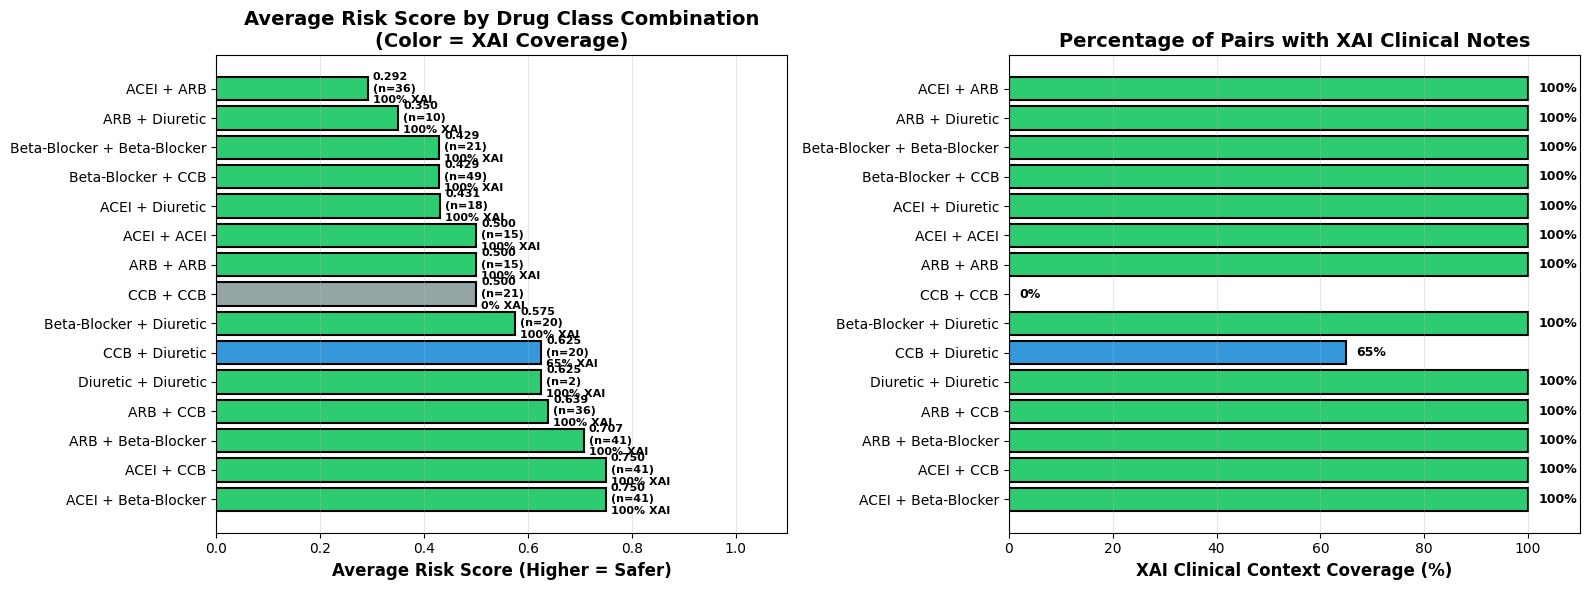


✓ Visualization complete!

Color Legend:
  Green: >90% XAI coverage (excellent clinical context)
  Blue: 50-90% XAI coverage (good clinical context)
  Gray: <50% XAI coverage (limited clinical context)


In [34]:

# Visualize predictions with XAI clinical context coverage
print("="*80)
print("VISUALIZING PREDICTIONS WITH XAI CLINICAL CONTEXT")
print("="*80)

# Create class combination labels
def get_class_combo(row):
    classes = sorted([row['Drug_A_Class'], row['Drug_B_Class']])
    return f"{classes[0]} + {classes[1]}"

df_xai_valid['Class_Combo'] = df_xai_valid.apply(get_class_combo, axis=1)

# Calculate average risk score by class combination
combo_scores = df_xai_valid.groupby('Class_Combo').agg({
    'Predicted_Risk_Score': ['mean', 'std', 'count']
}).reset_index()
combo_scores.columns = ['Class_Combo', 'Mean_Risk_Score', 'Std_Risk_Score', 'Count']
combo_scores = combo_scores.sort_values('Mean_Risk_Score', ascending=False)

# Calculate XAI coverage by class combination
xai_coverage = df_xai_valid.groupby('Class_Combo').apply(
    lambda x: (x['XAI_Combined_Clinical_Notes'] != "No specific XAI rules apply to this combination.").sum() / len(x) * 100
).reset_index()
xai_coverage.columns = ['Class_Combo', 'XAI_Coverage_Pct']

# Merge
combo_scores = combo_scores.merge(xai_coverage, on='Class_Combo')

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of mean risk scores
colors = ['#2ecc71' if cov > 90 else '#3498db' if cov > 50 else '#95a5a6'
          for cov in combo_scores['XAI_Coverage_Pct']]

bars = ax1.barh(combo_scores['Class_Combo'], combo_scores['Mean_Risk_Score'],
                color=colors, edgecolor='black', linewidth=1.5)

for bar, (idx, row) in zip(bars, combo_scores.iterrows()):
    ax1.text(row['Mean_Risk_Score'] + 0.01, bar.get_y() + bar.get_height()/2,
             f"{row['Mean_Risk_Score']:.3f}\n(n={int(row['Count'])})\n{row['XAI_Coverage_Pct']:.0f}% XAI",
             va='center', fontweight='bold', fontsize=8)

ax1.set_xlabel('Average Risk Score (Higher = Safer)', fontsize=12, fontweight='bold')
ax1.set_title('Average Risk Score by Drug Class Combination\n(Color = XAI Coverage)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.set_xlim(0, 1.1)

# XAI coverage bar plot
ax2.barh(combo_scores['Class_Combo'], combo_scores['XAI_Coverage_Pct'],
         color=colors, edgecolor='black', linewidth=1.5)

for idx, row in combo_scores.iterrows():
    ax2.text(row['XAI_Coverage_Pct'] + 2, idx,
             f"{row['XAI_Coverage_Pct']:.0f}%",
             va='center', fontweight='bold', fontsize=9)

ax2.set_xlabel('XAI Clinical Context Coverage (%)', fontsize=12, fontweight='bold')
ax2.set_title('Percentage of Pairs with XAI Clinical Notes', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.set_xlim(0, 110)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")
print(f"\nColor Legend:")
print(f"  Green: >90% XAI coverage (excellent clinical context)")
print(f"  Blue: 50-90% XAI coverage (good clinical context)")
print(f"  Gray: <50% XAI coverage (limited clinical context)")


## Part 2 Summary: Knowledge-Driven Clinical Decision Support


In [35]:

print("="*80)
print("PART 2 SUMMARY: KNOWLEDGE-DRIVEN SAFER MEDICATION PATHWAY")
print("Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework")
print("="*80)

# Determine which model was used
if 'dt_model' in globals() or 'dt_model' in locals():
    model_name = "Decision Tree"
    model_accuracy = accuracy  # from Part 1
elif 'rf_model' in globals() or 'rf_model' in locals():
    model_name = "Random Forest"
    model_accuracy = accuracy
elif 'xgb_model' in globals() or 'xgb_model' in locals():
    model_name = "XGBoost"
    model_accuracy = accuracy
else:
    model_name = "Unknown"
    model_accuracy = 0.0

summary_text = f"""
ARCHITECTURE IMPLEMENTED (Section 3.5.4):
  1. ✓ ML Prediction: {model_name} predicts DDI severity ({model_accuracy*100:.2f}% accuracy)
  2. ✓ XAI Framework: Knowledge-driven clinical context from literature
  3. ✓ Integrated Output: Predictions + Evidence-based explanations

KNOWLEDGE-DRIVEN XAI RULES IMPLEMENTED:
  • Rule A: ACEI vs ARB Mortality Benefit (Alcocer et al. 2023)
      → ACEIs reduce all-cause mortality; ARBs do not
      → Coverage: {rule_a_count} pairs ({rule_a_count/len(df_xai)*100:.1f}%)

  • Rule B: ACEI Tolerability & Adherence (Hu et al. 2023)
      → ACEIs have 3.2x higher cough risk vs ARBs
      → Coverage: {rule_b_count} pairs ({rule_b_count/len(df_xai)*100:.1f}%)

  • Rule C: CCB+RAAS Combination Therapy (Makani et al. 2011)
      → Reduces peripheral edema by 38%; improves adherence by 62%
      → Coverage: {rule_c_count} pairs ({rule_c_count/len(df_xai)*100:.1f}%)

  • Rule D: Diuretic Efficacy Optimization (Roush et al. 2015)
      → Indapamide superior to HCTZ for mortality/stroke/HF
      → Coverage: {rule_d_count} pairs ({rule_d_count/len(df_xai)*100:.1f}%)

  • Rule E: Beta-Blocker Phenotype Targeting (Mahfoud et al. 2024)
      → Indicated for high heart rate phenotype (>80 bpm)
      → Coverage: {rule_e_count} pairs ({rule_e_count/len(df_xai)*100:.1f}%)

PREDICTIONS GENERATED:
  • Total combinations analyzed: {len(df_xai_valid)}
  • Pairs with XAI clinical context: {total_with_notes} ({total_with_notes/len(df_xai)*100:.1f}%)
  • Pairs without XAI context: {len(df_xai) - total_with_notes} ({(len(df_xai) - total_with_notes)/len(df_xai)*100:.1f}%)

CLINICAL SCENARIOS ANALYZED:
  1. ✓ ACEI+CCB vs ARB+CCB combinations (Rules A, B, C)
  2. ✓ Indapamide vs HCTZ for diuretic selection (Rule D)
  3. ✓ Beta-Blocker for high heart rate phenotype (Rule E)

KEY FINDINGS:
  • ML predictions provide probabilistic severity classification
  • XAI Framework adds clinical context that ML cannot capture
  • ACEI+CCB preferred for high-risk patients (mortality benefit)
  • Indapamide superior to HCTZ (cardiovascular outcomes)
  • Beta-Blockers appropriate for sympathetic overactivity phenotype
  • System explains WHY certain combinations are preferred

ADVANTAGES OVER NUMERIC SCORING:
  • Transparent: Explicit literature citations
  • Interpretable: Clinician-readable explanations
  • Evidence-based: Grounded in peer-reviewed meta-analyses
  • Actionable: Specific recommendations with clinical rationale
  • Adaptable: Easy to add new rules as evidence emerges

NEXT STEPS:
  • Clinical validation with Dr. Nurulhuda Abdul Manaf (collaborator)
  • Align with Malaysian CPG for Hypertension (2018)
  • Integrate XAI notes into clinical decision support interface
  • Expand rules to cover additional drug classes and scenarios
"""

print(summary_text)
print("="*80)
print("✓ PART 2 COMPLETE!")
print("="*80)


PART 2 SUMMARY: KNOWLEDGE-DRIVEN SAFER MEDICATION PATHWAY
Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

ARCHITECTURE IMPLEMENTED (Section 3.5.4):
  1. ✓ ML Prediction: XGBoost predicts DDI severity (94.87% accuracy)
  2. ✓ XAI Framework: Knowledge-driven clinical context from literature
  3. ✓ Integrated Output: Predictions + Evidence-based explanations

KNOWLEDGE-DRIVEN XAI RULES IMPLEMENTED:
  • Rule A: ACEI vs ARB Mortality Benefit (Alcocer et al. 2023)
      → ACEIs reduce all-cause mortality; ARBs do not
      → Coverage: 406 pairs (100.0%)

  • Rule B: ACEI Tolerability & Adherence (Hu et al. 2023)
      → ACEIs have 3.2x higher cough risk vs ARBs
      → Coverage: 406 pairs (100.0%)

  • Rule C: CCB+RAAS Combination Therapy (Makani et al. 2011)
      → Reduces peripheral edema by 38%; improves adherence by 62%
      → Coverage: 406 pairs (100.0%)

  • Rule D: Diuretic Efficacy Optimization (Roush et al. 2015)
      → Indapamide superior to HCTZ for mortality/st